In [36]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
%matplotlib inline

In [2]:
data = pd.read_csv('Time_series/sp500_index.csv')
data.head()

,Date,S&P500
0,2014-10-17,1886.76
1,2014-10-20,1904.01
2,2014-10-21,1941.28
3,2014-10-22,1927.11
4,2014-10-23,1950.82


In [3]:
data['Date'] = pd.to_datetime(data['Date'])

#data = data[(data['Date'].dt.year >= 2020) & (data['Date'].dt.year <= 2024)]

In [4]:
print(data.shape)
print(data.dtypes)

(2516, 2)
Date      datetime64[ns]
S&P500           float64
dtype: object


In [5]:
data.isnull().values.any()

False

In [6]:
data.describe()

,Date,S&P500
count,2516,2516.000000
mean,2019-10-17 07:17:50.270270208,3275.335537
min,2014-10-17 00:00:00,1829.080000
25%,2017-04-18 18:00:00,2373.470000
50%,2019-10-16 12:00:00,2945.495000
75%,2022-04-15 00:00:00,4154.607500
max,2024-10-16 00:00:00,5859.850000
std,NaN,1032.744674


### Exploratory Data Analysis

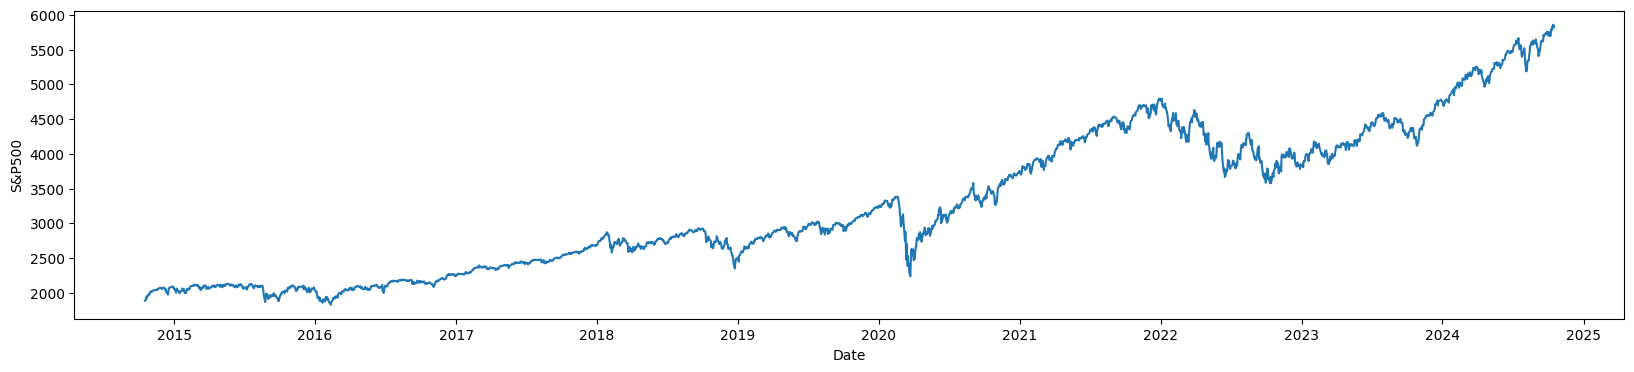

In [7]:
# plot car count over all years
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])
plt.show()

Abbiamo osservato che nel 2020 c'è un forte picco verso il basso che altera la tendenza nei dati. Analizziamo successivamente in dettaglio cosa succede

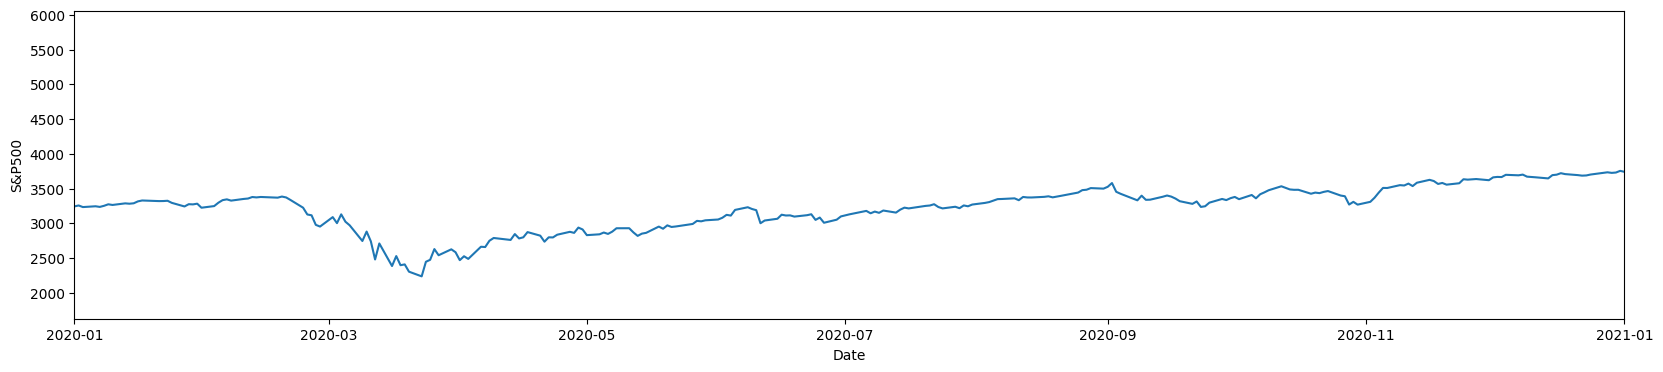

In [8]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

Si può notare che il grande picco verso il basso si può ricollegare all'inizio del COVID, nei mesi di marzo aprile 2020. Successivamente si nota una graduale ripresa

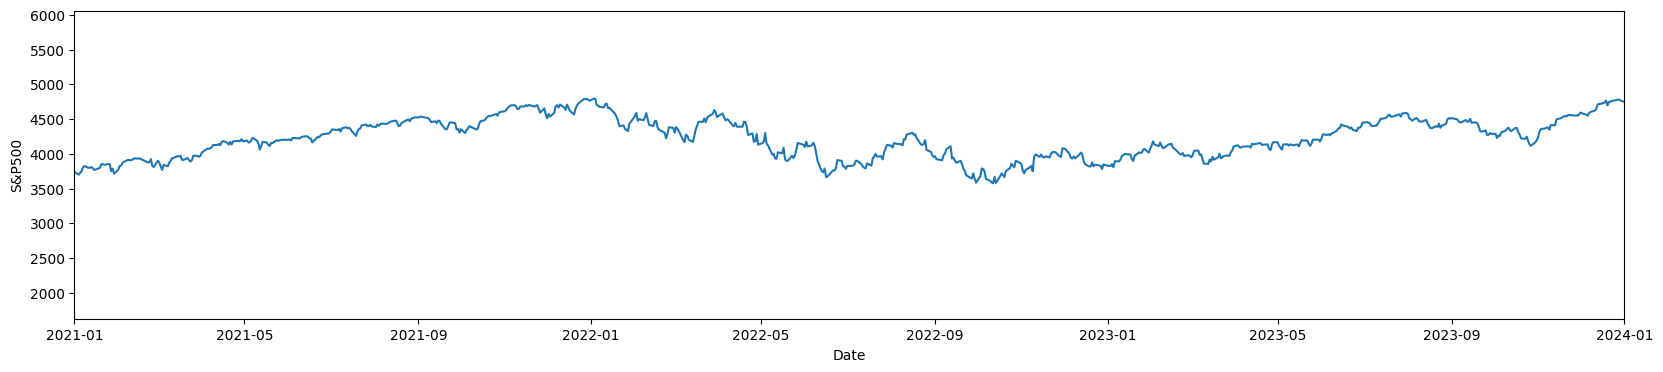

In [9]:
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2024,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

un altro momento di picco verso il basso si ha ad inizio 2022 fino al 2023, ricollegabile alla difficile situazione geopolitica tra russia e ucraina

In [10]:
# Rimuovi i dati dal 2020-01-01 al 2020-05-31
#data_filter = data[~((data['Date'] >= '2020-01-01') & (data['Date'] <= '2020-05-31'))]

# Rimuovi dati da anni precedenti al 2022 o successivi al 2023
#data_new = data_filter[~((data_filter['Date'] >= '2022-01-01') & (data_filter['Date'] <= '2023-01-01'))]

data_new = data

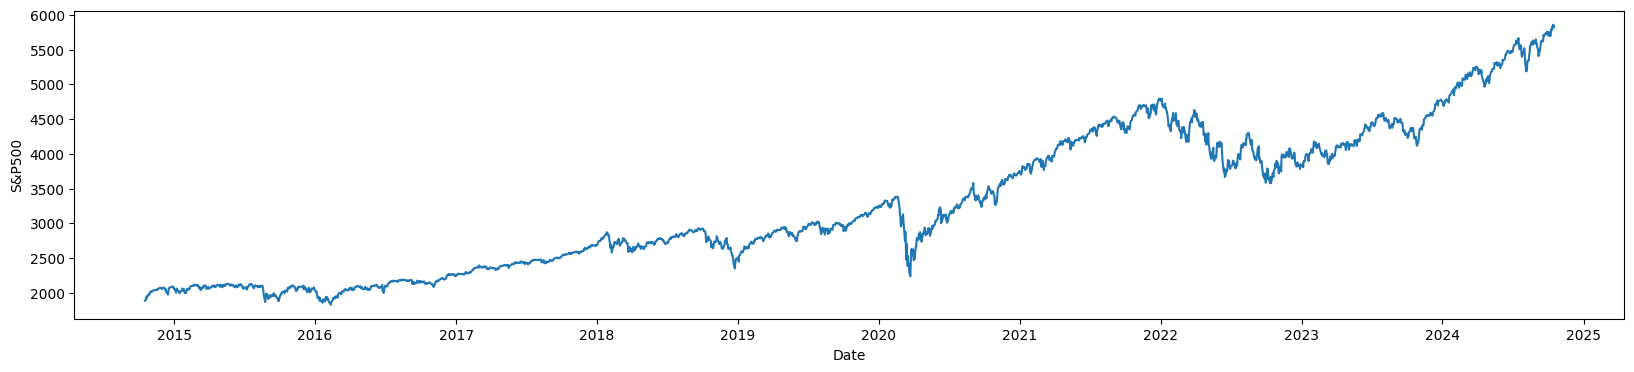

In [11]:
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data_new['Date'], data_new['S&P500'])
plt.show()

#### Suddivisione dataset training-test 80/20

In [12]:
# Definiamo la proporzione per il training (ad esempio 80% per il training e 20% per il test)
train_size = int(len(data_new) * 0.8)
train_data = data_new['S&P500'][:train_size]
test_data = data_new['S&P500'][train_size:]

# Visualizza le dimensioni
print("Total size:", len(data_new))
print("Training set size:", len(train_data))
print("Test set size:", len(test_data))

# Visualizzare le prime righe dei dati di training e test
print("Training Data (prime righe):")
print(train_data.head())
print("\nTest Data (prime righe):")
print(test_data.head())

# Visualizzare le ultime righe dei dati di training e test
print("Training Data (ultime righe):")
print(train_data.tail())
print("\nTest Data (ultime righe):")
print(test_data.tail())


Total size: 2516
Training set size: 2012
Test set size: 504
Training Data (prime righe):
0    1886.76
1    1904.01
2    1941.28
3    1927.11
4    1950.82
Name: S&P500, dtype: float64

Test Data (prime righe):
2012    3583.07
2013    3677.95
2014    3719.98
2015    3695.16
2016    3665.78
Name: S&P500, dtype: float64
Training Data (ultime righe):
2007    3639.66
2008    3612.39
2009    3588.84
2010    3577.03
2011    3669.91
Name: S&P500, dtype: float64

Test Data (ultime righe):
2511    5780.05
2512    5815.03
2513    5859.85
2514    5815.26
2515    5842.47
Name: S&P500, dtype: float64


## Forecasting

### Stationarity

In [13]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value']
    df_test = adfuller(ts)
    df_results = pd.Series(df_test[0:2], index=stats)
    
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])

In [14]:
test_stationarity(train_data)

ADF statistic: -1.0637077456192092
P-value: 0.7293257970386852


Questo valore è molto alto, vicino a 1.
Un valore p così elevato indica che non hai evidenza sufficiente per rifiutare l'ipotesi nulla (H₀), che afferma che la serie non è stazionaria. Quindi serie non stazionaria (media, varianza o covarianza variano nel tempo). Per renderla stazonaria applicando le differenze ecc.

In [15]:
(train_data - train_data.shift(1)).head()

0      NaN
1    17.25
2    37.27
3   -14.17
4    23.71
Name: S&P500, dtype: float64

In [16]:
train_data.diff().head()

0      NaN
1    17.25
2    37.27
3   -14.17
4    23.71
Name: S&P500, dtype: float64

In [17]:
test_stationarity(train_data.diff().dropna())

ADF statistic: -13.032732516477381
P-value: 2.3268314776619475e-24


Questo valore di ADF è ora molto negativo, il che suggerisce una forte evidenza contro l'ipotesi nulla (H₀). Un p-value così basso conferma che possiamo rifiutare l'ipotesi nulla (H₀) con grande confidenza. Concludiamo quindi che la serie è stazionaria dopo la differenziazione.

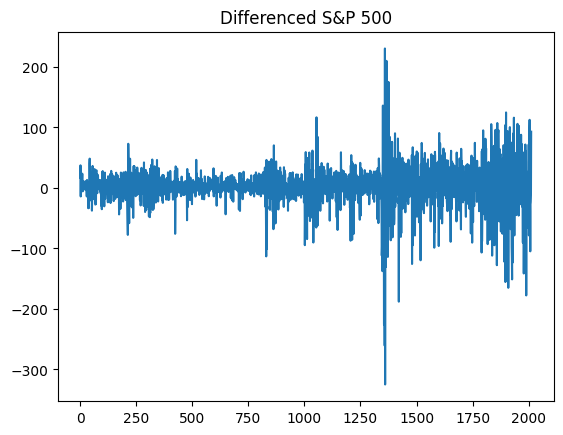

In [18]:
import matplotlib.pyplot as plt
train_data.diff().dropna().plot(title="Differenced S&P 500")
plt.show()

### ACF and PACF graphs

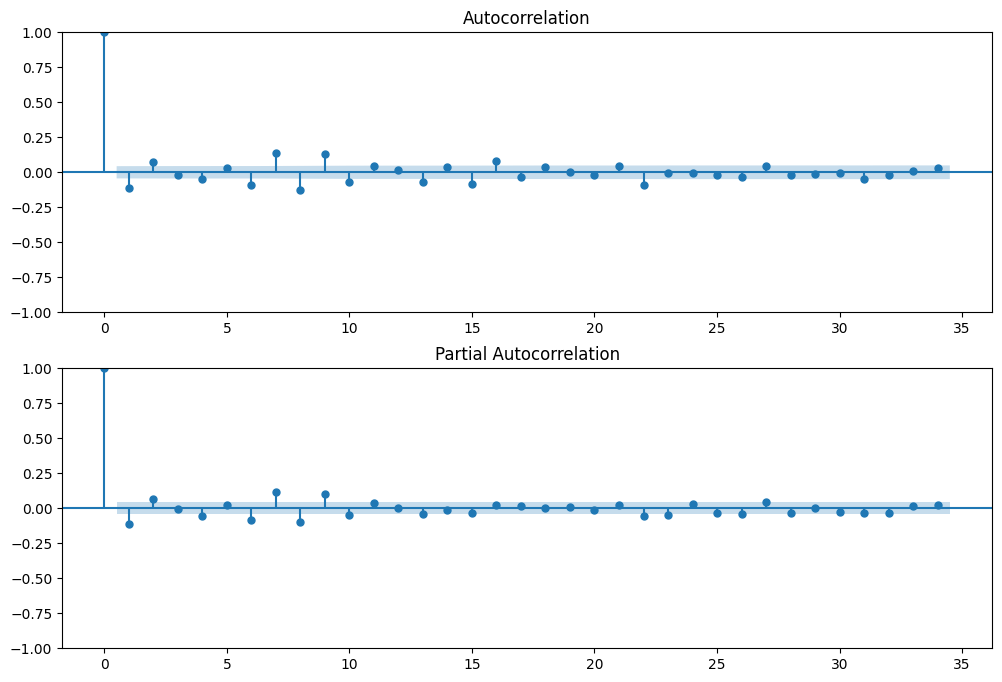

In [19]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data.diff()[1:],  ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data.diff()[1:], ax=ax2)

Possiamo notare una stagionalità intorno ai valori 6/8, quindi quei valori sono correlati con quelli dei 6/8 giorni precedenti (dipendo da quelli)

Primo valore 1 in entrambi perché Il primo lag (ritardo 0) di entrambe le funzioni mostra la correlazione della serie con sé stessa, che è sempre 1 (ovvero perfettamente correlata). Tutti gli altri valori sono prossimi allo zero, Questo comportamento suggerisce che la serie differenziata è quasi rumore bianco:
Un rumore bianco non ha una struttura prevedibile, il che significa che i valori futuri non dipendono linearmente dai valori passati. Possiamo provare quindi un ARIMA con d=1, p=0 (AR) e q=0 (MA).
- (0,1,0) 
- Auto_Arima (2,1,2)

### Fitting Model

In [20]:
# Modello ARIMA
model = ARIMA(train_data, order=(0, 1, 0))
results_base = model.fit()

# Sommario del modello
print(results_base.summary())

                               SARIMAX Results                                
Dep. Variable:                 S&P500   No. Observations:                 2012
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -10045.609
Date:                Sat, 16 Nov 2024   AIC                          20093.218
Time:                        17:24:32   BIC                          20098.825
Sample:                             0   HQIC                         20095.276
                               - 2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1277.6579     16.493     77.465      0.000    1245.331    1309.984
Ljung-Box (L1) (Q):                  24.56   Jarque-Bera (JB):              8704.97
Prob(Q):                              0.00   Pr

c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


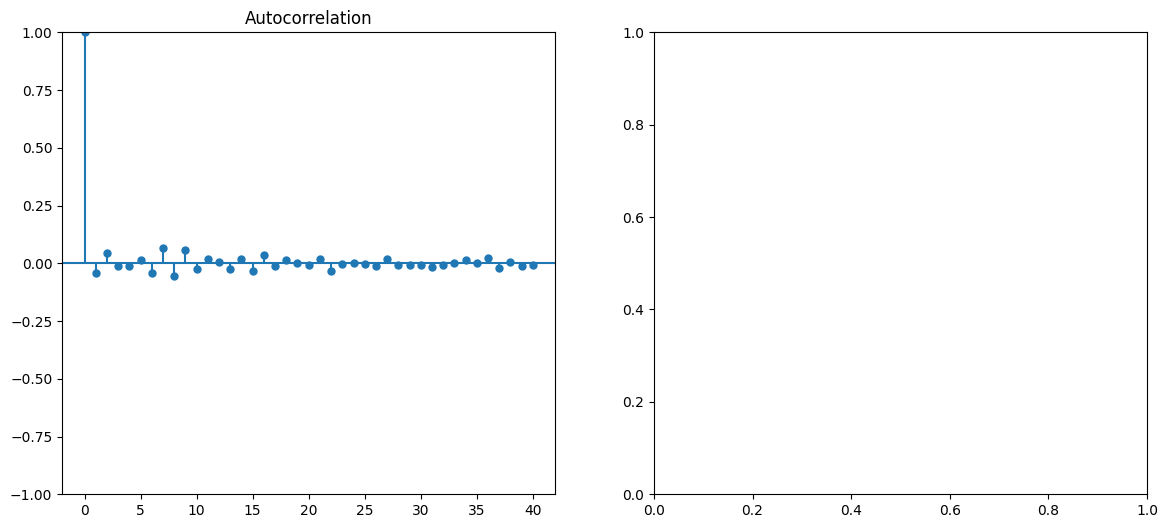

<Figure size 640x480 with 0 Axes>

In [21]:
# Previsione dei residui
from pmdarima import plot_acf, plot_pacf


residuals = results_base.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

### Test di Ljun-Box sui residui

In [31]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
     lb_stat  lb_pvalue
10  2.762409   0.986476
20  4.244600   0.999925
30  8.069206   0.999978


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Trova automaticamente il miglior modello SARIMA con auto_arima
#model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)
model = auto_arima(train_data, seasonal=True, m=6, stepwise=True, trace=True)

# Stampa i parametri del miglior modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=20056.670, Time=13.82 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=20093.980, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=20061.278, Time=1.89 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=20063.587, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=20093.218, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=20055.430, Time=10.53 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=19987.659, Time=7.66 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=20054.565, Time=9.68 sec
 ARIMA(1,1,2)(0,0,0)[6] intercept   : AIC=20066.027, Time=2.66 sec
 ARIMA(2,1,1)(0,0,0)[6] intercept   : AIC=20066.812, Time=1.01 sec
 ARIMA(3,1,2)(0,0,0)[6] intercept   : AIC=19988.252, Time=8.47 sec
 ARIMA(2,1,3)(0,0,0)[6] intercept   : AIC=20066.575, Time=7.39 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=20067.742, Time=1.94 sec
 ARIMA(1,1,3)(0,0,0)[6] intercept   : AIC=20065.637, Time=5.70 sec
 ARIMA(3,1,1)(0,0

                               SARIMAX Results                                
Dep. Variable:                 S&P500   No. Observations:                 2012
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -9988.553
Date:                Sat, 16 Nov 2024   AIC                          19987.107
Time:                        17:36:50   BIC                          20015.139
Sample:                             0   HQIC                         19997.397
                               - 2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7578      0.017   -102.131      0.000      -1.792      -1.724
ar.L2         -0.8858      0.016    -55.101      0.000      -0.917      -0.854
ma.L1          1.6742      0.022     75.416      0.0

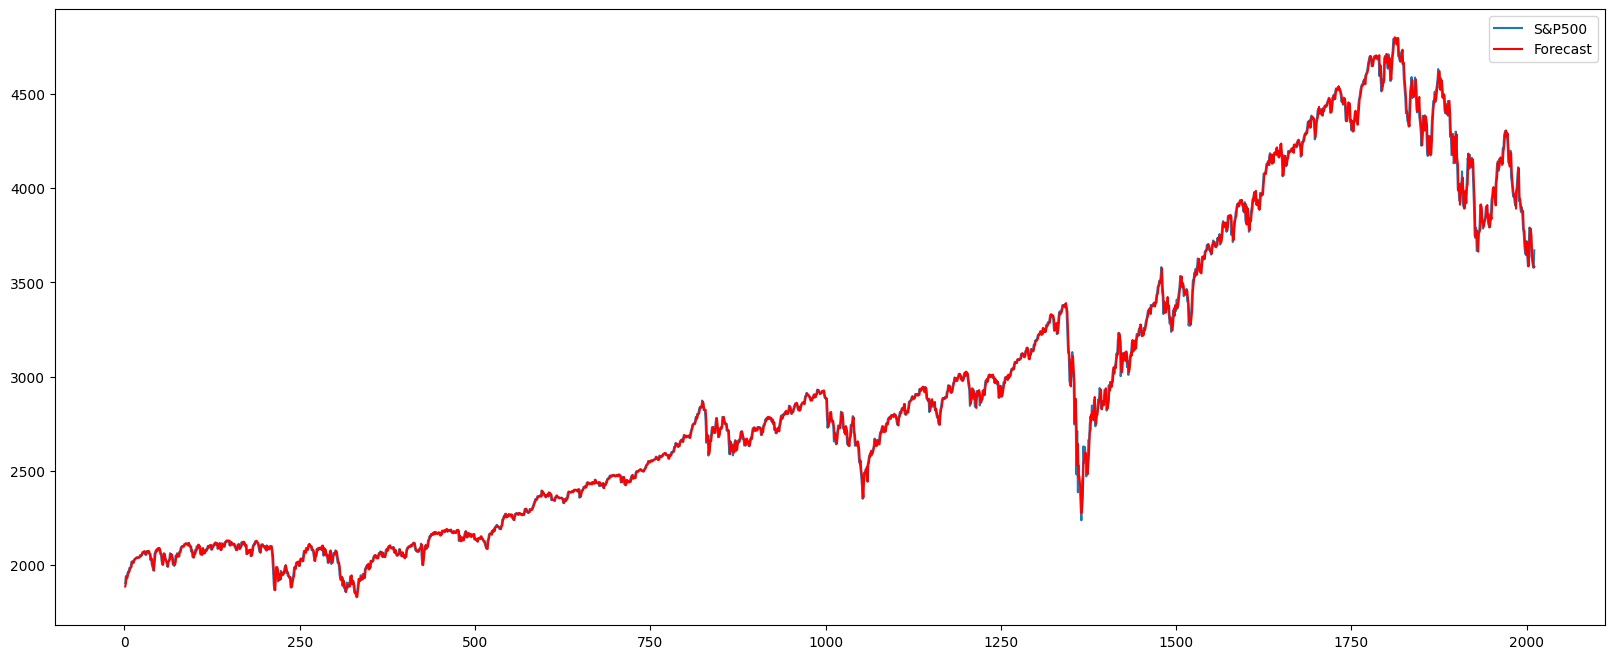

In [37]:
# fit ARIMA model
""" fig = plt.figure(figsize=(20,8))
model = ARIMA(train_data, order=(2,1,2)) 
ax = plt.gca()
results = model.fit() 
plt.plot(train_data[1:])
plt.plot(results.fittedvalues[1:], color='red')
ax.legend(['S&P500', 'Forecast'])

print(results.summary()) """
# Fit del modello SARIMA con i parametri trovati da auto_arima
model = SARIMAX(train_data, order=(2,1,2), seasonal_order=(0,0,0,6))
results = model.fit()

# Visualizza il grafico
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(train_data[1:])
plt.plot(results.fittedvalues[1:], color='red')
ax.legend(['S&P500', 'Forecast'])

# Mostra il sommario dei risultati
print(results.summary())

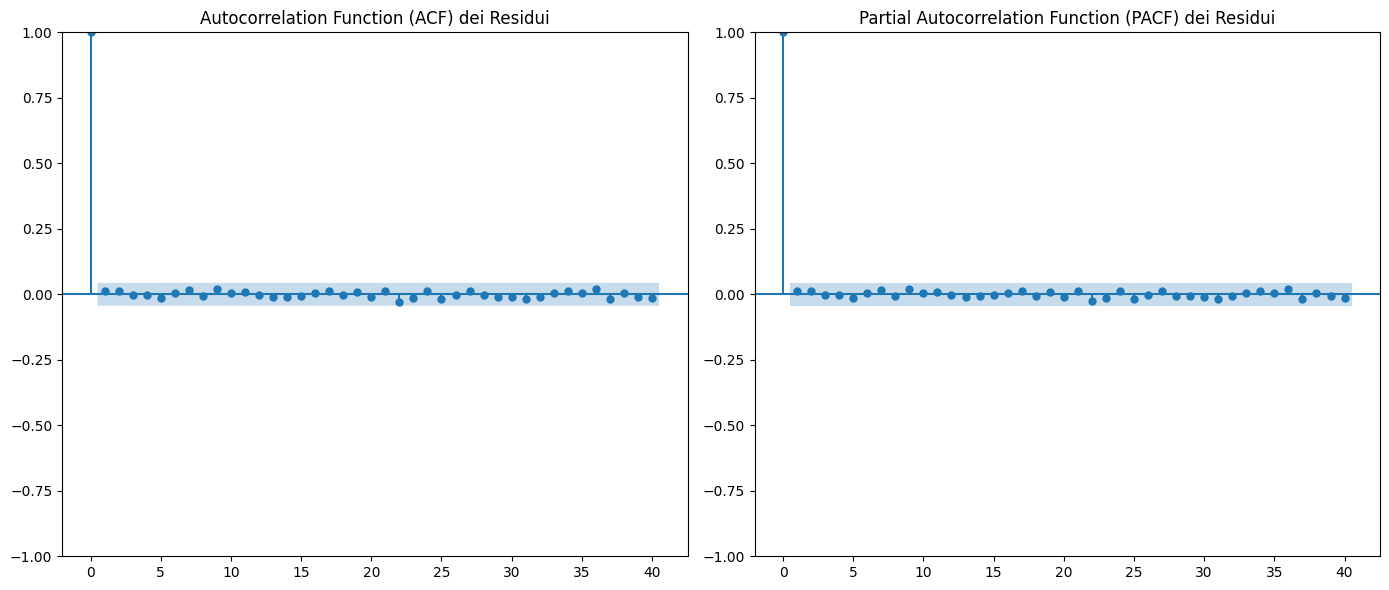

In [38]:
# Previsione dei residui
residuals = results.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

### Test di Ljung-Box

In [39]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
     lb_stat  lb_pvalue
10  2.762409   0.986476
20  4.244600   0.999925
30  8.069206   0.999978


I valori di p-value sopra la soglia di 0.05 indicano che i residui non mostrano correlazioni significative e inoltre indica che il modello ha catturato le principali dinamiche della serie temporale. In linea con i risultati di ACF e PACF vicini allo zero.

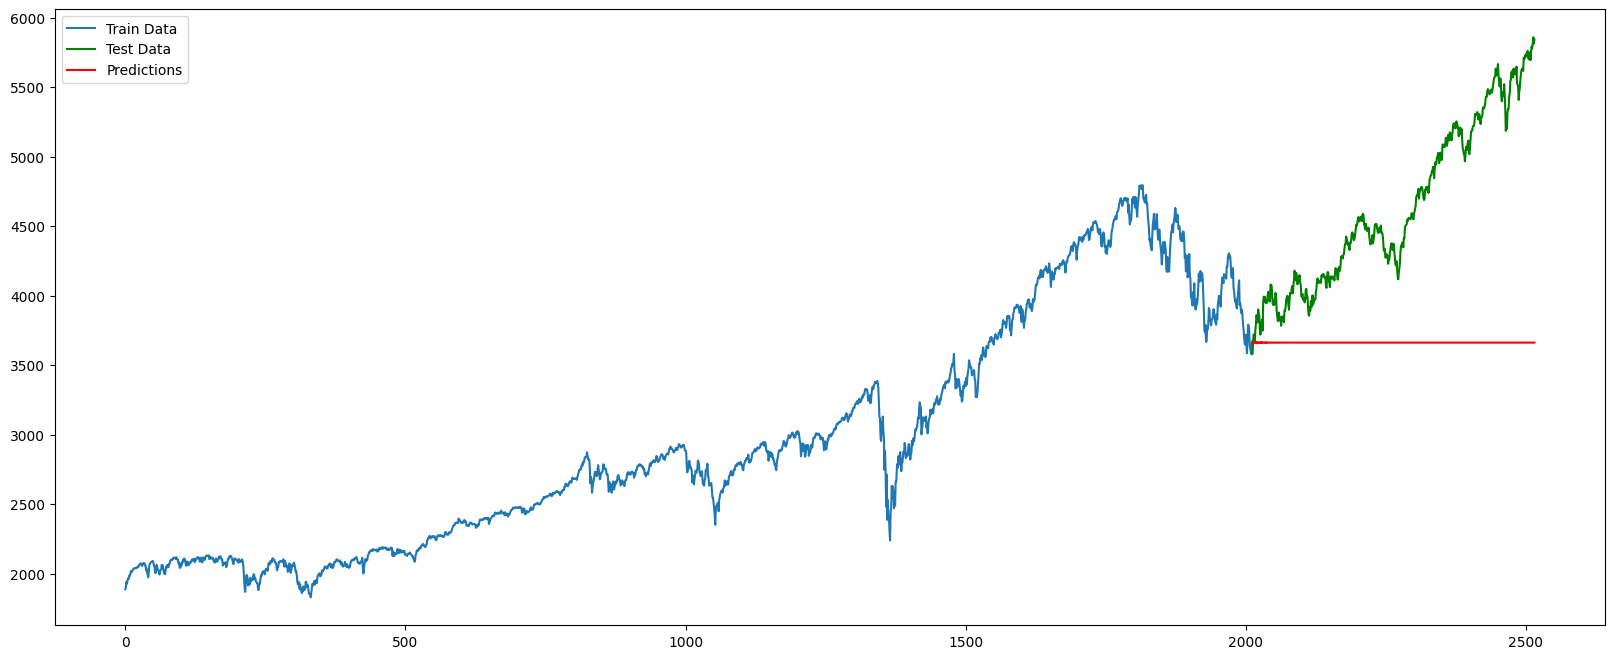

In [44]:
# Previsioni sui dati di training (per controllare le previsioni nel training set)
#x_train_pred = results.predict(start=0, end=len(train_data)-1, dynamic=False)

# Previsione per l'intervallo del test set
x_test_pred = results.predict(start=len(train_data), end=len(data_new)-1, dynamic=False)

# Visualizza i risultati
fig = plt.figure(figsize=(20,8))
plt.plot(train_data, label="Train Data")
plt.plot(test_data, label="Test Data", color='g')  # Aggiungiamo i dati di test per il confronto
plt.plot(range(len(train_data), len(data_new)), x_test_pred, color='r', label="Predictions")  # Previsioni sul test set
#plt.plot(range(len(train_data)), x_train_pred, color='b', label="Train Predictions")  # Previsioni sul training set
plt.legend()
plt.show()